In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
import os
os.chdir('/content/drive/My Drive/73Strings/')

In [2]:
!pip install transformers

     |████████████████████████████████| 675kB 2.7MB/s 
     |████████████████████████████████| 3.8MB 13.5MB/s 
     |████████████████████████████████| 1.1MB 30.5MB/s 
     |████████████████████████████████| 890kB 32.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=28bcbafa8eee5d8eee91515708fe73cf23d96d6eacea999c8d68380beb9c5e82
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
train_excel = pd.read_excel('https://mcusercontent.com/68e43b9f99dfe0f747fbff957/files/95a68be7-975b-4922-94d7-0bf1e33e46e8/Training_Data_Set_for_Data_Science_Case_Study.xlsx')
test_excel = pd.read_excel('https://mcusercontent.com/68e43b9f99dfe0f747fbff957/files/64111b00-2d46-40f2-a5ad-558a33d8d62a/Testing_Data_for_Data_Science_Case_Stduy.xlsx')

In [16]:
label_encoder = {t:i for i,t in enumerate(train_excel['Industry Classification Tag'].unique())}

In [17]:
train_excel['Industry Classification Tag'] = train_excel['Industry Classification Tag'].apply(label_encoder.get).fillna(len(label_encoder)+1)

In [154]:
# EDA on TAGS
from matplotlib.pyplot import figure
import numpy as np

In [128]:
train_excel['Industry Classification Tag'].isna().any()

False

In [132]:
tag = train_excel['Industry Classification Tag']
tag.to_list()
len(np.unique(tag))                    #There are 62 lables

62

In [139]:
# Number of companies corresponding to a particular class
train_excel.groupby(['Company Name','Industry Classification Tag']).size().reset_index().groupby('Industry Classification Tag').sum()

,0
Industry Classification Tag,
0,113
1,74
2,58
3,106
4,205
...,...
57,60
58,51
59,73


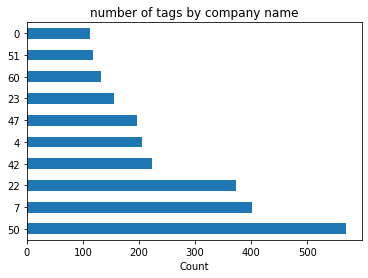

In [151]:
%matplotlib inline

train_excel['Industry Classification Tag'].value_counts().nlargest(10).plot(kind = 'barh')
plt.title("number of tags by company name")
plt.xlabel("Count")
plt.show()

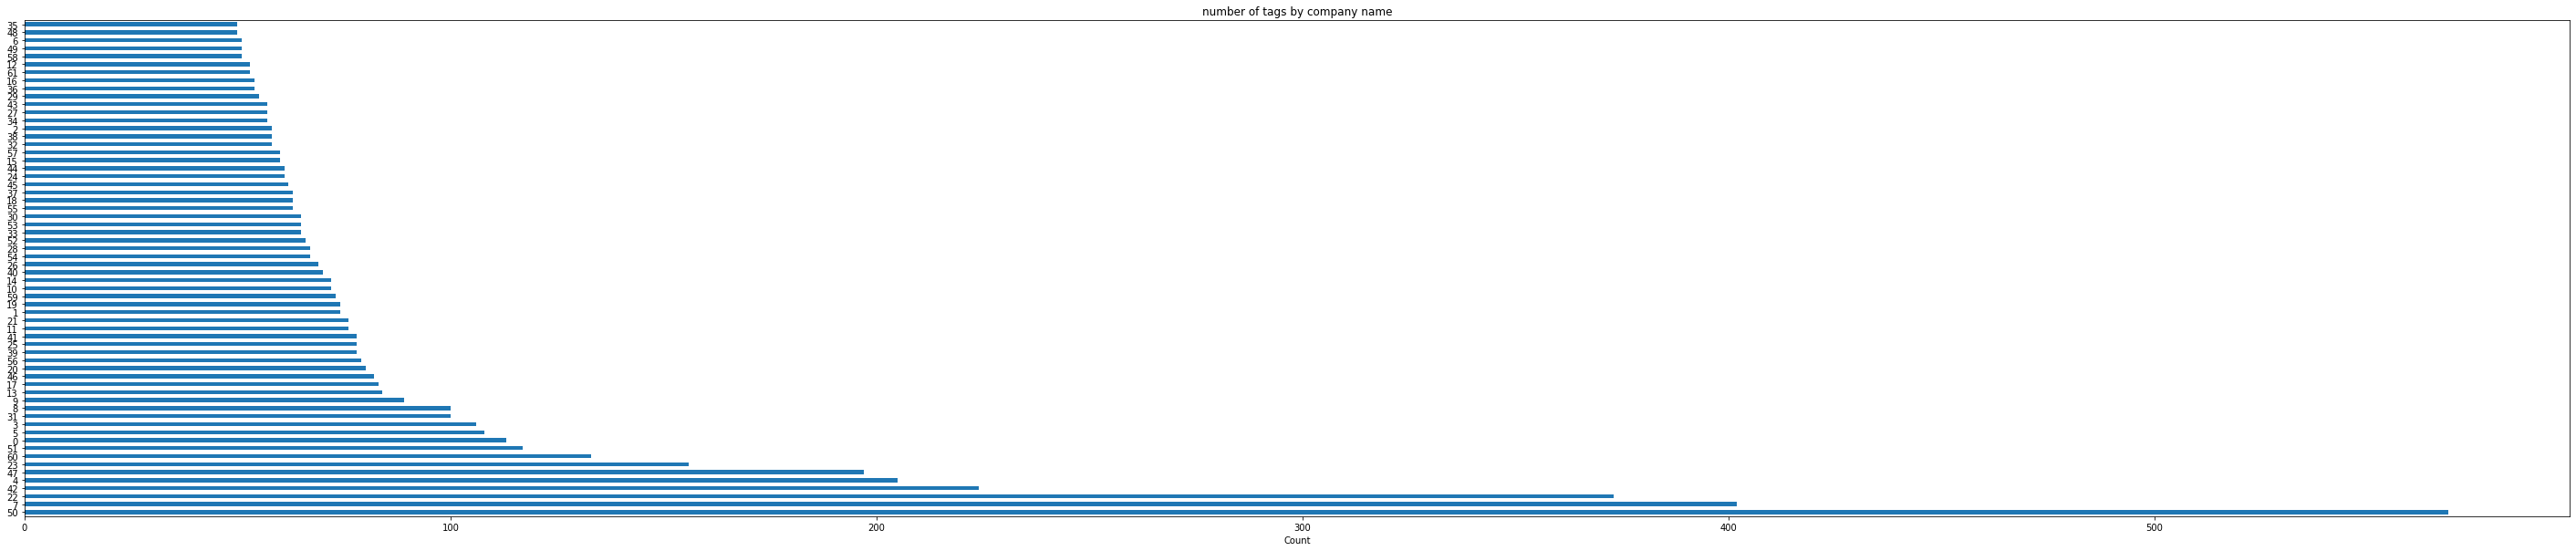

In [157]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 50,10
train_excel['Industry Classification Tag'].value_counts().nlargest(62).plot(kind = 'barh')
# fig = 
# plt.set_size_inches(18.5, 10.5)
plt.title("number of tags by company name")
plt.xlabel("Count")
plt.show()

In [23]:
train_excel.fillna("").to_csv('train.csv', index=False)
test_excel.fillna("").to_csv('test.csv', index=False)

In [37]:
test_excel

,Company,Business Description
0,3rd Rock Multimedia Ltd,3rd Rock Multimedia Limited is an India-based ...
1,Andhra Petrochemicals Ltd,The Andhra Petrochemicals Limited is an India-...
2,Force Motors Ltd,Force Motors Limited is a holding company. The...
3,Diamines And Chemicals Ltd,Diamines and Chemicals Limited is a holding co...
4,Insilco Ltd,Insilco Limited is engaged in manufacturing an...
...,...,...
767,Wheels India Ltd,Wheels India Limited is a steel wheel manufact...
768,Xchanging Solutions Ltd,Xchanging Solutions Limited is engaged in comp...
769,Zensar Technologies Limited,Zensar Technologies Limited (Zensar) is a Indi...
770,Zodiac Energy Ltd,Zodiac Energy Limited is an India-based energy...


In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize=tokenizer.encode, include_lengths=False, batch_first=True, sequential=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX, use_vocab=False)
fields = [('Company Name', text_field), ('Business Description', text_field), ('Industry Classification Tag', label_field)]

In [21]:
cuda_obj = torch.device(0)

In [25]:
train_dataset = TabularDataset(path='train.csv', format='CSV', fields=fields, skip_header=True)
train_train_dataset, train_val_dataset = train_dataset.split()
train_iter = BucketIterator(train_train_dataset, batch_size=16,
                            train=True, device=cuda_obj)
valid_iter = BucketIterator(train_val_dataset, batch_size=16, device=cuda_obj)

In [26]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertModel.from_pretrained(options_name)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(768, len(label_encoder))
        self.encoder.init_weights()

    def forward(self, text):
        # loss, text_fea = self.encoder(text, labels=label)[:2]
        pooled_output = self.encoder(text)[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [27]:
model = BERT().cuda()

In [ ]:
# for param in list(model.encoder.parameters())[:-35]:
#     param.requires_grad = False

In [28]:
for l in model.encoder.encoder.layer[:-1]:
    for param in l.parameters():
        param.requires_grad = False

In [29]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fct = nn.CrossEntropyLoss()

In [84]:
from tqdm import tqdm, trange, tqdm_notebook
min_val_loss = 1000

num_epochs = 40
for epoch in tqdm_notebook(range(num_epochs)):
    model.train()
    losses = []
    for (company, text, labels), _ in tqdm_notebook(train_iter):
        labels = labels.type(torch.LongTensor)           
        labels = labels.to(cuda_obj)
        text = text.type(torch.LongTensor)  
        text = text.to(cuda_obj)
        output = model(text)
        loss = loss_fct(output, labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Train Loss', sum(losses)/len(losses))
    model.eval()
    valid_losses = []
    for (company, text, labels), _ in tqdm_notebook(valid_iter):
        labels = labels.type(torch.LongTensor)           
        labels = labels.to(cuda_obj)
        text = text.type(torch.LongTensor)  
        text = text.to(cuda_obj)
        output = model(text)
        loss = loss_fct(output, labels)
        valid_losses.append(loss.item())
    val_loss = sum(valid_losses)/len(valid_losses)
    print('Validation Loss', val_loss)
    if val_loss < min_val_loss:
        print('Best model till now')
        torch.save(model, 'best_model.model')
        min_val_loss = val_loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Train Loss 3.9159967080602107


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Validation Loss 3.8732776662759614
Best model till now


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BERT. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Train Loss 3.8480734285318627



Validation Loss 3.6593080842704104
Best model till now



Train Loss 3.453480463207893



Validation Loss 3.1311479367707906
Best model till now



Train Loss 3.055246536236889



Validation Loss 2.8770402513052287
Best model till now



Train Loss 2.812463808959385



Validation Loss 2.6639582347451594
Best model till now



Train Loss 2.6053118602284844



Validation Loss 2.4781310401464762
Best model till now



Train Loss 2.4012718673022286



Validation Loss 2.2996348749127304
Best model till now



Train Loss 2.202076917324426



Validation Loss 2.145613594013348
Best model till now



Train Loss 2.0300947859602156



Validation Loss 2.018157392217402
Best model till now



Train Loss 1.8608074930478942



Validation Loss 1.9172272603762777
Best model till now



Train Loss 1.7108711105472636



Validation Loss 1.8284359020099306
Best model till now



Train Loss 1.5703363391588319



Validation Loss 1.7541903707019069
Best model till now



Train Loss 1.4549459459646692



Validation Loss 1.6864951603245317
Best model till now



Train Loss 1.3159563604390847



Validation Loss 1.6543526654703575
Best model till now



Train Loss 1.1973080954461728



Validation Loss 1.6205845203316003
Best model till now



Train Loss 1.094327065404856



Validation Loss 1.5852233673396863
Best model till now



Train Loss 0.9880516589812512



Validation Loss 1.5570581236429382
Best model till now



Train Loss 0.8903172546962522



Validation Loss 1.5465690634752576
Best model till now



Train Loss 0.7959009087310647



Validation Loss 1.5284194705779093
Best model till now



Train Loss 0.7158225976071267



Validation Loss 1.5177094690632402
Best model till now



Train Loss 0.6233058237804556



Validation Loss 1.5482762220658755



Train Loss 0.5489109974987102



Validation Loss 1.5224241854851706



Train Loss 0.4814265934926159



Validation Loss 1.5347378635615634



Train Loss 0.4167733038371464



Validation Loss 1.524614063271305



Train Loss 0.3755828460432448



Validation Loss 1.5365466363074487



Train Loss 0.3136930099073446



Validation Loss 1.5706961115724163



Train Loss 0.272057639652828



Validation Loss 1.571477466246538



Train Loss 0.240843669198594



Validation Loss 1.5752050782504834



Train Loss 0.20123395784845893



Validation Loss 1.5913152744372685



Train Loss 0.17871804001196376



Validation Loss 1.5945462239416022



Train Loss 0.1564170885760829



Validation Loss 1.6179421737528683



Train Loss 0.13266209757552958



Validation Loss 1.6490175679587482



Train Loss 0.11269426964363961



Validation Loss 1.6299342633339398



Train Loss 0.10460364863557636



Validation Loss 1.660452120921068



Train Loss 0.08986241581305018



Validation Loss 1.6514415450786288



Train Loss 0.07648883866813948



Validation Loss 1.6765953453355713



Train Loss 0.07223827951359299



Validation Loss 1.7045649666535228



Train Loss 0.06009044680955275



Validation Loss 1.7171395538668883



Train Loss 0.05661742136163531



Validation Loss 1.7211795457099612



Train Loss 0.05342771838296134



Validation Loss 1.7577284025518518



In [85]:
from tqdm import tqdm, trange, tqdm_notebook

best_model = torch.load('best_model.model')

all_labels = []
all_predictions = []
for (company, text, labels), _ in tqdm_notebook(valid_iter):
    all_labels.extend(labels.tolist())
    output = best_model(text)
    all_predictions.extend(output.argmax(axis=1).tolist())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [101]:
reverse_label_encoder = {i:k for k,i in label_encoder.items()}
all_labels = [reverse_label_encoder[i] for i in all_labels]
all_predictions = [reverse_label_encoder[i] for i in all_predictions]
print(classification_report(all_labels, all_predictions))

                                            precision    recall  f1-score   support

                               Advertising       0.57      0.49      0.53        43
                       Aerospace & Defense       0.45      0.62      0.53        16
                            Apparel Retail       0.92      0.63      0.75        19
       Apparel, Accessories & Luxury Goods       0.57      0.85      0.69        27
                      Application Software       0.41      0.65      0.50        63
          Asset Management & Custody Banks       0.46      0.59      0.52        27
                    Auto Parts & Equipment       0.60      0.25      0.35        12
                             Biotechnology       0.72      0.85      0.78       115
                         Building Products       0.48      0.42      0.45        38
                          Casinos & Gaming       0.83      0.77      0.80        26
                       Commodity Chemicals       0.24      0.23      0.23  

In [ ]:
all_labels

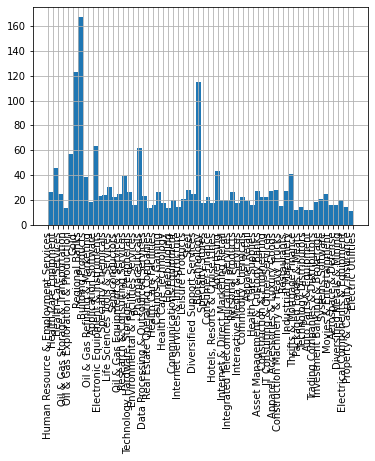

In [103]:
%matplotlib inline
pd.Series(all_labels).hist(xrot=90, bins=62)

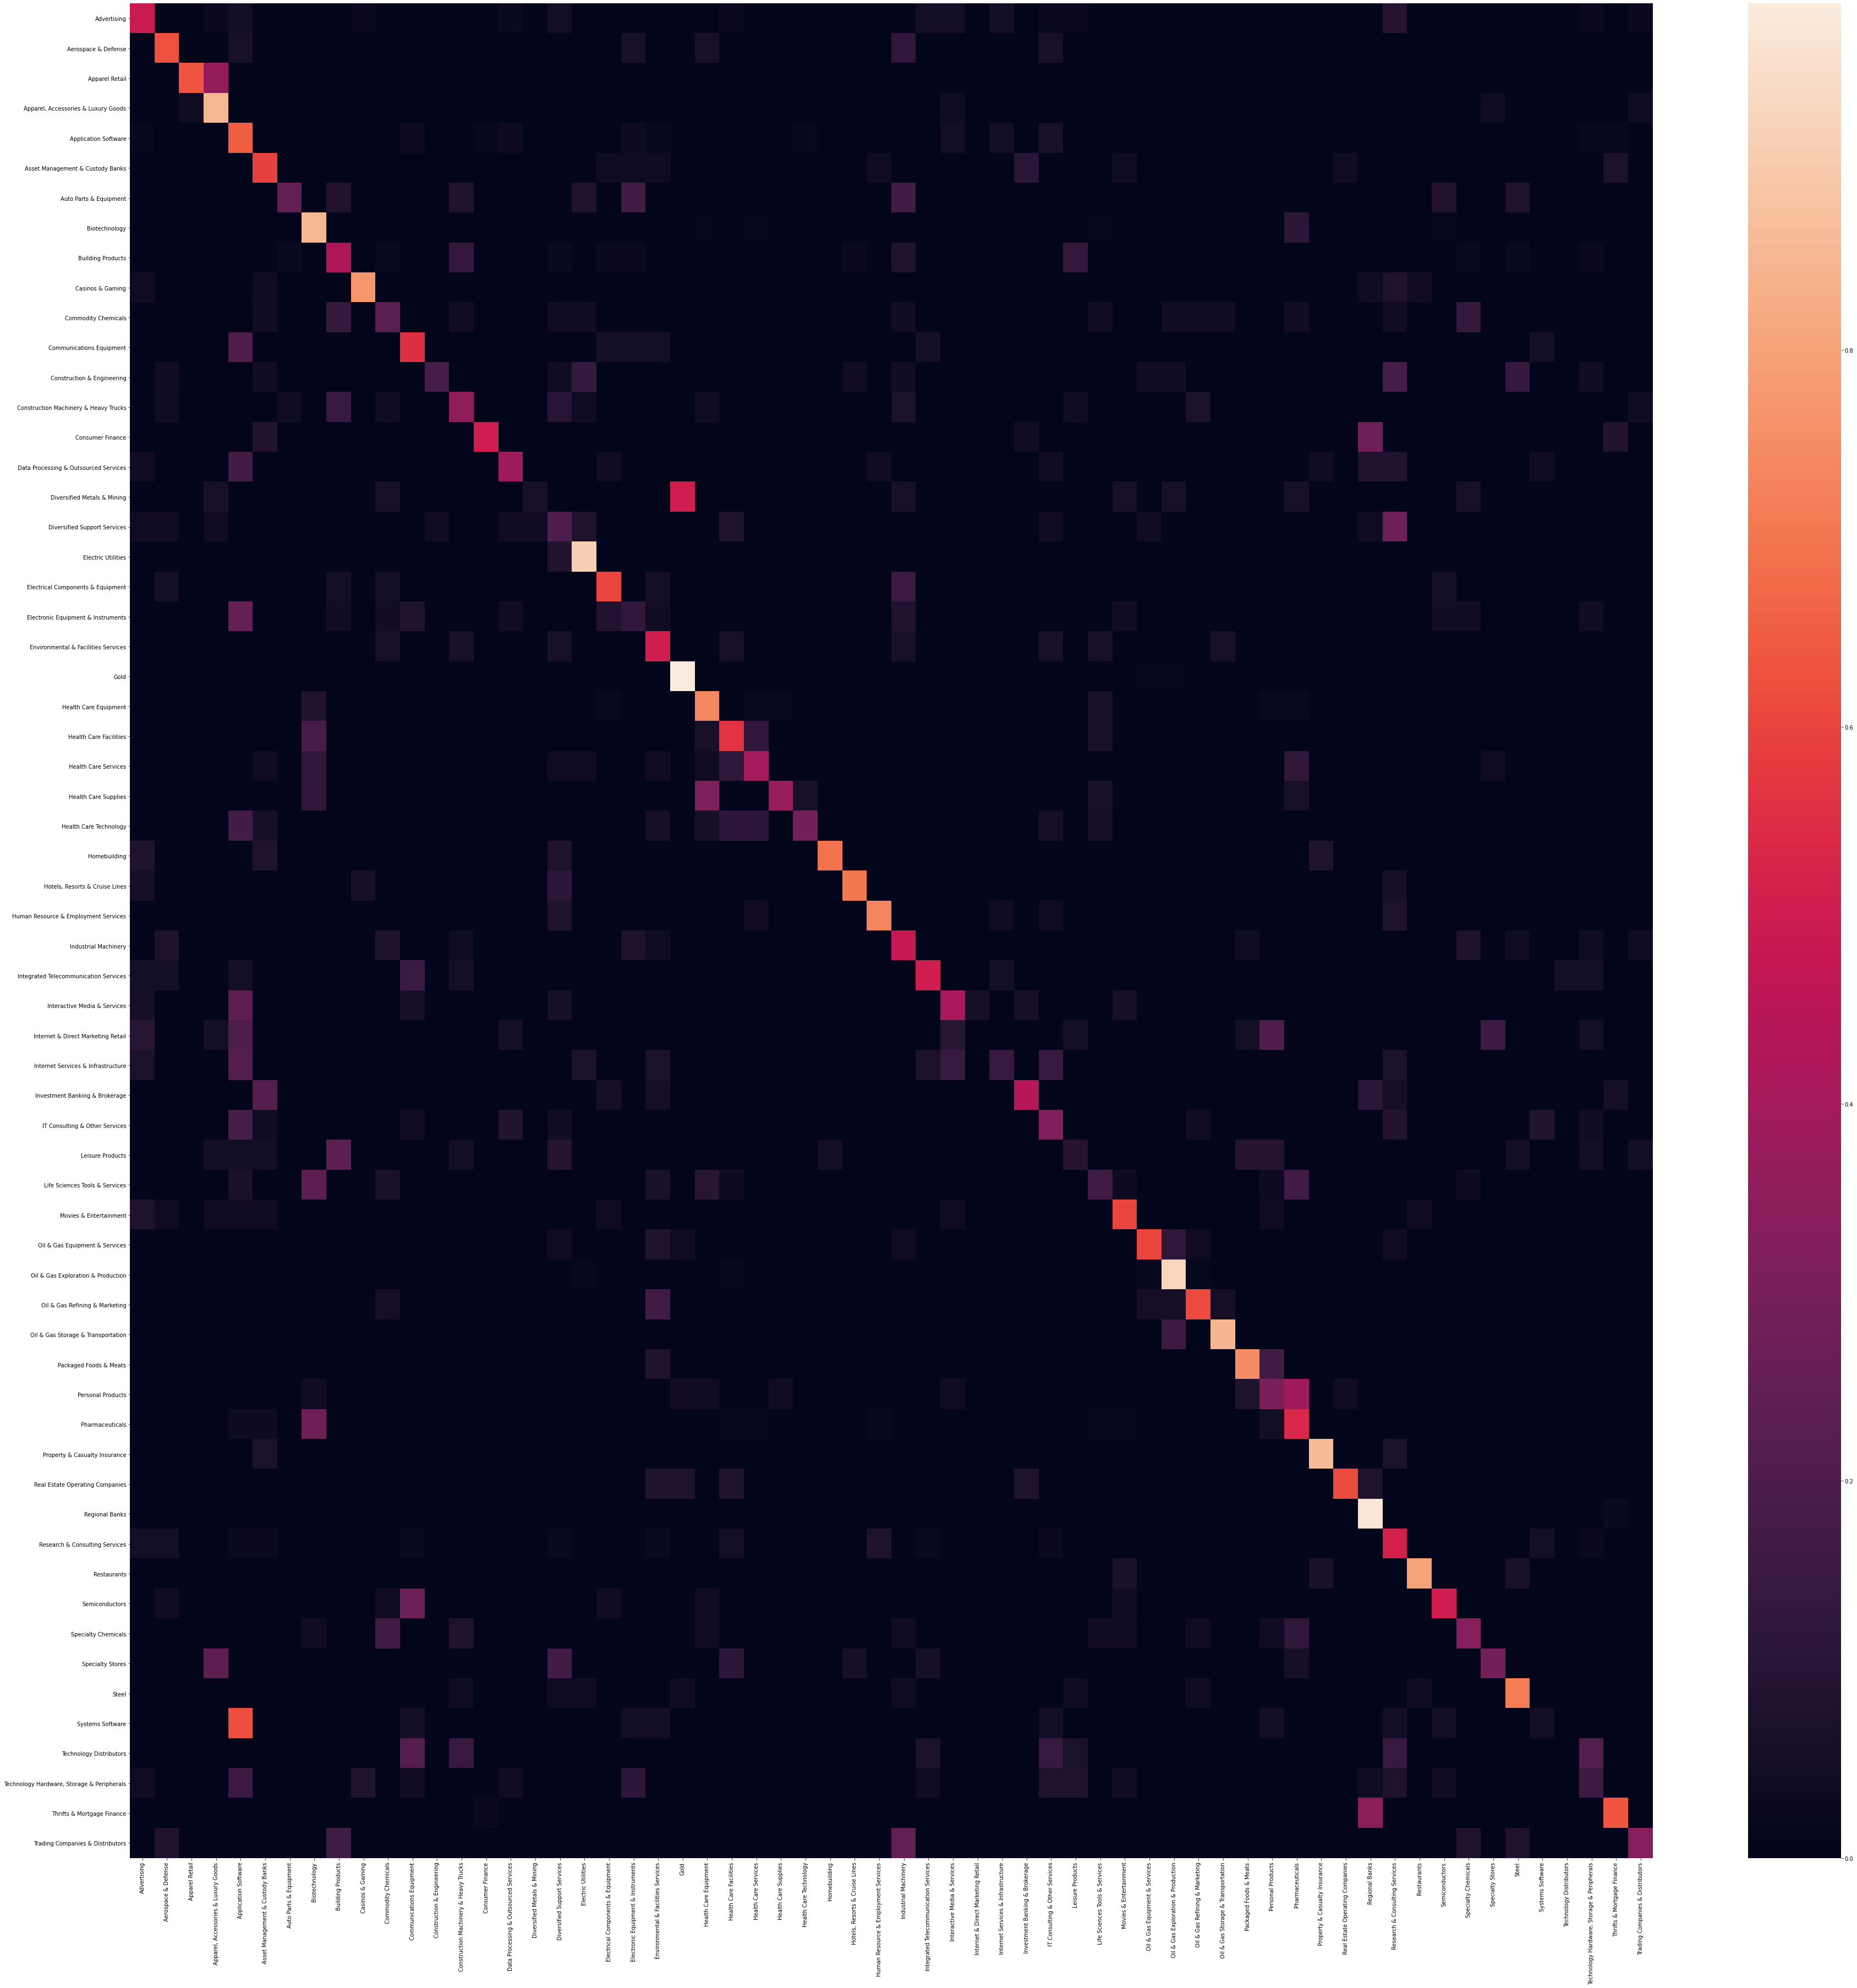

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = list(label_encoder.keys())
array=confusion_matrix(all_labels,all_predictions, labels=labels, normalize='true')
df_cm = pd.DataFrame(array, index = labels,
                  columns = labels)
plt.figure(figsize = (len(labels),len(labels)))
sns.heatmap(df_cm, annot=False)

In [91]:
# TEST MODEL

In [92]:
test_fields = [('Company Name', text_field), ('Business Description', text_field)]

In [93]:
test_dataset = TabularDataset(path='test.csv', format='CSV', fields=test_fields, skip_header=True)
test_iter = BucketIterator(test_dataset, batch_size=16,device=cuda_obj)

In [94]:
all_predictions_test = []
all_companies_encoded = []
for (company, text), _ in tqdm_notebook(test_iter):
    all_companies_encoded.extend(company.tolist())
    output = best_model(text)
    all_predictions_test.extend(output.argmax(axis=1).tolist())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [95]:
all_predictions_test_labelled = [reverse_label_encoder[i] for i in all_predictions_test]

In [96]:
encoded_company_label_dict = {tuple(filter(lambda x: x, c)):l for c,l in zip(all_companies_encoded, all_predictions_test_labelled)}

In [97]:
test_excel['Industry Classification Tag'] = test_excel['Company '].apply(lambda x: tuple(tokenizer.encode(x))).apply(encoded_company_label_dict.get)

In [98]:
test_excel.to_csv('test_output.csv', index=False)

In [100]:
test_excel

,Company,Business Description,Industry Classification Tag
0,3rd Rock Multimedia Ltd,3rd Rock Multimedia Limited is an India-based ...,Movies & Entertainment
1,Andhra Petrochemicals Ltd,The Andhra Petrochemicals Limited is an India-...,Commodity Chemicals
2,Force Motors Ltd,Force Motors Limited is a holding company. The...,Construction Machinery & Heavy Trucks
3,Diamines And Chemicals Ltd,Diamines and Chemicals Limited is a holding co...,Commodity Chemicals
4,Insilco Ltd,Insilco Limited is engaged in manufacturing an...,Specialty Chemicals
...,...,...,...
767,Wheels India Ltd,Wheels India Limited is a steel wheel manufact...,Steel
768,Xchanging Solutions Ltd,Xchanging Solutions Limited is engaged in comp...,IT Consulting & Other Services
769,Zensar Technologies Limited,Zensar Technologies Limited (Zensar) is a Indi...,Application Software
770,Zodiac Energy Ltd,Zodiac Energy Limited is an India-based energy...,Electrical Components & Equipment
